[INFO] loading image...
[INFO] loading pre-trained ResNet50 model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[INFO] generating pertubation...
step: 0, loss: -0.00031132620642893016...
step: 5, loss: -0.0009657248156145215...
step: 10, loss: -0.0052413432858884335...
step: 15, loss: -0.06327299773693085...
step: 20, loss: -0.772819459438324...
step: 25, loss: -3.461536169052124...
step: 30, loss: -7.539944171905518...
step: 35, loss: -13.637591361999512...
step: 40, loss: -22.046428680419922...
step: 45, loss: -31.40088653564453...
[INFO] running inference on adversarial example...
[INFO] label: wombat, confidence: 100.0%


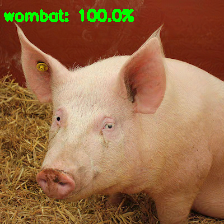

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
from google.colab.patches import cv2_imshow
import tensorflow as tf
import numpy as np
import cv2 as cv

def preprocess_image(image):
    # swap color channels, preprocess image, and add in batch dimension
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (224, 224))
    image = np.expand_dims(image, axis=0)
    
    return image

def clip_eps(tensor, eps):
    # clip the values of tensor to a given range and return it
    return tf.clip_by_value(tensor, clip_value_min=-eps, clip_value_max=eps)

def generate_adversaries(model, base_image, delta, class_idx, steps=50):
    # iterate over the number of steps
    for step in range(0, steps):
        # record our gradients
        with tf.GradientTape() as tape:
            # explicitly indicate that our perturbation vector should be tracked for gradient
            # update
            tape.watch(delta)
            
            # add out perturbation vector to base image and preprocess resulting image
            adversary = preprocess_input(base_image + delta)
            
            # run this newly constructed image tensor through our model and calculate loss w.r.t
            # *original* class index
            predictions = model(adversary, training=False)
            loss = -sccLoss(tf.convert_to_tensor([class_idx]), predictions)
            
            # check to see if we are logging the loss value, and if so display to terminal
            if step%5 == 0:
                print(f'step: {step}, loss: {loss.numpy()}...')
        
        # calculate gradient of loss w.r.t pertubation vector
        gradients = tape.gradient(loss, delta)
        
        # update weights, clip the pertubation vector and update its value
        optimizer.apply_gradients([(gradients, delta)])
        delta.assign_add(clip_eps(delta, eps=eps))
        
    return delta

# arguments
input_image = 'pig.jpg'
output_image = 'adversarial.png'
class_idx = 341

# define the epsilon and learning rate
eps = 2/255.0
lr = 0.1

# load the input image from disk and preprocess it
print('[INFO] loading image...')
image = cv.imread(input_image)
image = preprocess_image(image)

# load the pre-trained ResNet50 model
print('[INFO] loading pre-trained ResNet50 model...')
model = ResNet50(weights='imagenet')

# initialize optimizer and loss function
optimizer = Adam(lr=lr)
sccLoss = SparseCategoricalCrossentropy()

# create a tensor based off of input image and initialize the perturbation vector
base_image = tf.constant(image, dtype=tf.float32)
delta = tf.Variable(tf.zeros_like(base_image), trainable=True)

# generate the pertubation vector to create an adversarial example
print('[INFO] generating pertubation...')
delta_updated = generate_adversaries(model, base_image, delta, class_idx)

# create the adversarial example, swap color channels, and save image to disk
adverse_image = (base_image + delta_updated).numpy().squeeze()
adverse_image = np.clip(adverse_image, 0, 255).astype('uint8')
adverse_image = cv.cvtColor(adverse_image, cv.COLOR_RGB2BGR)
cv.imwrite(output_image, adverse_image)

# run the inference with this adversarial example, parse results, and display
# top-1 predicted result
print('[INFO] running inference on adversarial example...')
preprocessed_image = preprocess_input(base_image + delta_updated)
predictions = model.predict(preprocessed_image)
predictions = decode_predictions(predictions, top=3)[0]
label = predictions[0][1]
confidence = predictions[0][2] * 100
print(f'[INFO] label: {label}, confidence: {confidence}%')

# draw top most predicted label on adversarial image along with confidence score
text = f'{label}: {confidence}%'
cv.putText(adverse_image, text, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

cv2_imshow(adverse_image)